In [134]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, optimizers, Input, regularizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa
from tensorboard.plugins.hparams import api as hp
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import time
import os
from time import sleep
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import pprint
import pywt
tf.__version__

'2.8.0'

In [2]:
%load_ext tensorboard

In [3]:
start = time.perf_counter()

In [4]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [5]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


### Create Log directories for Tensorboard

In [6]:
# try:
#     if not os.path.exists("logs"):
#         log_path = os.path.join("logs","fit")
#         os.makedirs(os.path.join(log_path,"lstm","bidirectional"))
#         os.mkdir(os.path.join(log_path,"cnn"))
#         print("log files are created")
#     else:
#         print("log files already exist")
# except Exception as e:
#     print(e)
#     print("Error while creating log directories. Aborted.")

In [7]:
# image_path = "images"
# try:
#     os.mkdir(image_path)
    
# except Exception as e:
#     print(e)
#     print("Error while creating image directory. Aborted.")

### Load Data

In [8]:
X_x_train = np.loadtxt("./data/X_x_train.txt")
X_y_train = np.loadtxt("./data/X_y_train.txt")
X_z_train = np.loadtxt("./data/X_z_train.txt")
y_train = np.loadtxt("./data/y_train.txt")

X_x_test = np.loadtxt("./data/X_x_test.txt")
X_y_test = np.loadtxt("./data/X_y_test.txt")
X_z_test = np.loadtxt("./data/X_z_test.txt")
y_test = np.loadtxt("./data/y_test.txt")

### Normalize Data

In [9]:
norm = StandardScaler()

In [10]:
X_x_train_norm = norm.fit_transform(X_x_train)
X_y_train_norm = norm.fit_transform(X_y_train)
X_z_train_norm = norm.fit_transform(X_z_train)

X_x_test_norm = norm.fit_transform(X_x_test)
X_y_test_norm = norm.fit_transform(X_y_test)
X_z_test_norm = norm.fit_transform(X_z_test)

### Compile X, Y, Z data into train/test arrays

In [11]:
def concat_xyz(x,y,z):
    new_arr = np.empty((x.shape[0], 3, x.shape[1]))
    new_arr[:,0] = x
    new_arr[:,1] = y
    new_arr[:,2] = z
    return new_arr

In [12]:
X_xyz_norm_train =  concat_xyz(X_x_train_norm,X_y_train_norm, X_z_train_norm)
X_xyz_norm_test = concat_xyz(X_x_test_norm,X_y_test_norm,X_z_test_norm)

In [13]:
X_xyz_norm_train.shape

(7352, 3, 128)

For the training data, there are 7352 different trials for 3 channels of accelerometer data (x,y,z) sampled 128 times during each trial.

In [14]:
label_names = ['Walking', 'Walking upstairs', 'Walking downstairs', 'Sitting', 'Standing', 'Laying']
num_classes = len(label_names)
print(num_classes)

6


In [15]:
# shifting y_train to values from 0 to num_classes-1 (zero indexing)
y_train = y_train - 1
y_test = y_test - 1

### One hot encoding

In [16]:
y_ohe_train = to_categorical(y_train,num_classes)
y_ohe_test = to_categorical(y_test, num_classes)

#### Here are the current shapes of each variable

In [17]:
X_xyz_norm_train.shape

(7352, 3, 128)

In [18]:
X_xyz_norm_test.shape

(2947, 3, 128)

In [19]:
y_train.shape

(7352,)

In [20]:
y_test.shape

(2947,)

In [21]:
y_ohe_train.shape

(7352, 6)

In [22]:
y_ohe_test.shape

(2947, 6)

# Creating Continuous Wavelet Transforms representing time series data

### Showing the 1/7352 128-sample run

<function matplotlib.pyplot.show(close=None, block=None)>

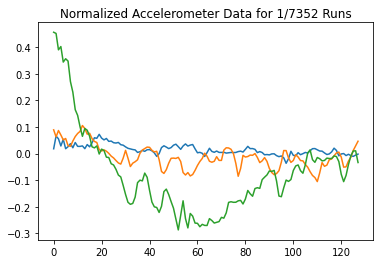

In [23]:
plt.title("Normalized Accelerometer Data for 1/7352 Runs")
plt.plot(X_xyz_norm_train[0][0])
plt.plot(X_xyz_norm_train[0][1])
plt.plot(X_xyz_norm_train[0][2])
# plt.savefig(os.path.join(image_path,
plt.show

#### Convert all data to wavelets

In [24]:
def find_length(a):
    return np.sqrt(np.dot(a,a))
    # np.sqrt((X_xyz_norm_train[0][0])**2+(X_xyz_norm_train[0][1])**2+(X_xyz_norm_train[0][2])**2)

In [25]:
X_xyz_norm_train_wave = np.apply_along_axis(find_length, len(X_xyz_norm_train.shape)-2 , X_xyz_norm_train)
X_xyz_norm_test_wave = np.apply_along_axis(find_length, len(X_xyz_norm_test.shape)-2 , X_xyz_norm_test)

<function matplotlib.pyplot.show(close=None, block=None)>

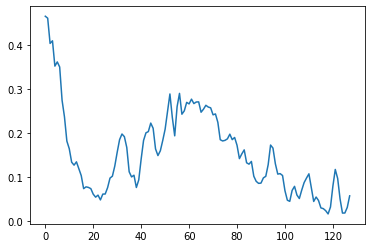

In [26]:
plt.plot(X_xyz_norm_train_wave[0])
plt.show

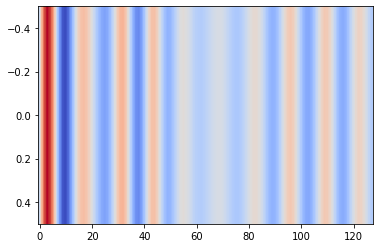

In [27]:
# samples taken at 50hz
coeffs, freqs = pywt.cwt(X_xyz_norm_train_wave[0],10,'morl')
plt.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')

Using Morlet wavelets

# Implementing CNN

## CNN for Raw Data

In [113]:
input_shape_cnn_raw = X_xyz_norm_train.shape[1:]
print(input_shape_cnn_raw)

(3, 128)


The original notebook used TF1 with placeholder. Here we take `(3, 128)` as input shape instead of `(None, 3, 128)`

In [177]:
cnn = models.Sequential()
cnn.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape_cnn_raw))
# cnn.add(layers.AveragePooling1D(pool_size=4))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(5,kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
cnn.add(layers.Dropout(.2))
cnn.add(layers.Dense(5, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
cnn.add(layers.Dropout(.2))
cnn.add(layers.Dense(5, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
cnn.add(layers.Dropout(.2))
cnn.add(layers.Dense(5, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
cnn.add(layers.Dropout(.2))
cnn.add(layers.Dense(5, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
cnn.add(layers.Dropout(.2))
cnn.add(layers.Dense(5, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
cnn.add(layers.Dropout(.2))
cnn.add(layers.Dense(5, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
cnn.add(layers.Dropout(.2))
cnn.add(layers.Dense(5, kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
cnn.add(layers.Dropout(.2))
cnn.add(layers.Dense(5, activation='relu'))
cnn.add(layers.Dropout(.2))

cnn.add(layers.Dense(num_classes,activation='softmax'))

Reducing Layer output and total layers solves overfitting

In [178]:
cnn.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_39 (Conv1D)          (None, 1, 32)             12320     
                                                                 
 flatten_29 (Flatten)        (None, 32)                0         
                                                                 
 dense_166 (Dense)           (None, 5)                 165       
                                                                 
 dropout_137 (Dropout)       (None, 5)                 0         
                                                                 
 dense_167 (Dense)           (None, 5)                 30        
                                                                 
 dropout_138 (Dropout)       (None, 5)                 0         
                                                                 
 dense_168 (Dense)           (None, 5)               

In [179]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
cnn.compile(optimizer=optimizers.Adam(),
           loss="categorical_crossentropy",
           metrics=[tf.keras.metrics.Accuracy(),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tfa.metrics.F1Score(num_classes = num_classes, average='micro')
                   ])

#### Creating Tensorboard logs, saving, and running model

In [180]:
log_dir = "logs/fit/cnn/raw/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
cnn_tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "models/cnn/raw/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

cnnhistory = cnn.fit(X_xyz_norm_train, y_ohe_train, epochs=100, batch_size = 100, validation_data=(X_xyz_norm_test, y_ohe_test),callbacks=[cnn_tensorboard_callback,checkpoint_callback])

Epoch 1/100
74/74 [==============================] - ETA: 0s - loss: 1.7863 - accuracy: 0.0000e+00 - precision_24: 0.5000 - recall_24: 2.7203e-04 - f1_score: 0.2180    
Epoch 1: saving model to models/cnn/raw\20220506-062923
74/74 [==============================] - 2s 14ms/step - loss: 1.7863 - accuracy: 0.0000e+00 - precision_24: 0.5000 - recall_24: 2.7203e-04 - f1_score: 0.2180 - val_loss: 1.7692 - val_accuracy: 0.0000e+00 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - val_f1_score: 0.2874
Epoch 2/100
66/74 [=========================>....] - ETA: 0s - loss: 1.7259 - accuracy: 0.0000e+00 - precision_24: 0.4360 - recall_24: 0.0139 - f1_score: 0.2586
Epoch 2: saving model to models/cnn/raw\20220506-062923
74/74 [==============================] - 1s 8ms/step - loss: 1.7245 - accuracy: 0.0000e+00 - precision_24: 0.4454 - recall_24: 0.0144 - f1_score: 0.2603 - val_loss: 1.6516 - val_accuracy: 0.0000e+00 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - val_f1_score

In [181]:
# %tensorboard --logdir logs/fit/cnn/raw

To run tensorboard in the CLI use command ```tensorboard --logdir logs/fit/cnn/raw```

In [ ]:
# loss_values = cnnhistory.history['loss']
# epochs = range(1, len(loss_values)+1)

# plt.plot(epochs, loss_values, label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [149]:
# acc_values = cnnhistory.history['accuracy']
# epochs = range(1, len(loss_values)+1)

# plt.plot(epochs, acc_values, label='Training Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

[5 5 5 ... 1 1 1]
[4. 4. 4. ... 1. 1. 1.]


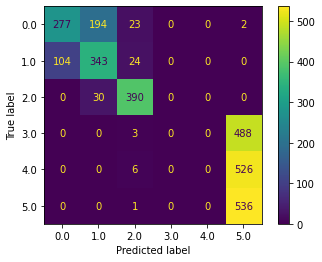

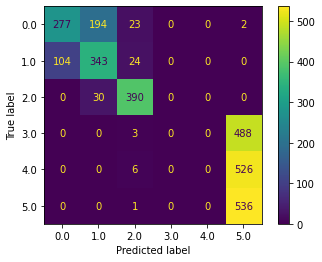

In [182]:
y_pred = np.argmax(cnn.predict(X_xyz_norm_test),axis=1)
print(y_pred)
# print(y_pred.shape)
# y_test_1D = np.argmax(y_test, axis=1).T[0]
# print(type(y_test_1D))
print(y_test)
# print(y_test_1D.shape)
conf = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
conf.plot()

## CNN for Wavelet Data (Everything after this point is not implemented yet)

In [183]:
input_shape_cnn_wave = X_xyz_norm_train_wave.shape[1:]
print(input_shape_cnn_wave)

(128,)


In [184]:
 X_xyz_norm_train_wave

array([[0.46497809, 0.46056655, 0.40328126, ..., 0.01841033, 0.03108204,
        0.05733563],
       [0.28809958, 0.27120431, 0.27913218, ..., 0.04833091, 0.06211145,
        0.06126569],
       [0.11004671, 0.08830186, 0.05559407, ..., 0.13230104, 0.13193443,
        0.13573401],
       ...,
       [2.35307348, 2.69820664, 2.88168575, ..., 1.77236511, 1.74065471,
        2.23211901],
       [2.76421729, 3.04361971, 3.42086075, ..., 2.29477835, 2.60264385,
        2.74023814],
       [2.16760845, 2.21070024, 2.98753595, ..., 2.03165587, 1.64946923,
        1.45769199]])

In [185]:
wavecnn = models.Sequential()
wavecnn.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape_cnn_wave))
# cnn.add(layers.AveragePooling1D(pool_size=2))
wavecnn.add(layers.Flatten())
wavecnn.add(layers.Dense(10, activation='relu'))
wavecnn.add(layers.Dropout(.2))
wavecnn.add(layers.Dense(10, activation='relu'))
wavecnn.add(layers.Dropout(.2))
wavecnn.add(layers.Dense(5, activation='relu'))
wavecnn.add(layers.Dropout(.2))

wavecnn.add(layers.Dense(num_classes,activation='softmax'))

ValueError: Input 0 of layer "conv1d_40" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 128)

In [ ]:
wavecnn.summary()

In [ ]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
wavecnn.compile(optimizer=optimizers.Adam(),
           loss="categorical_crossentropy",
           metrics=[tf.keras.metrics.Accuracy(),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tfa.metrics.F1Score(num_classes = num_classes, average='micro')
                   ])

In [ ]:
log_dir = "logs/fit/cnn/wave" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
wavecnn_tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "models/cnn/wave" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
wavecnn_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

cnnhistory = cnn.fit(X_xyz_norm_train_wave, y_ohe_train, epochs=100, batch_size = 75, validation_data=(X_xyz_norm_test_wave, y_ohe_test),callbacks=[wavecnn_tensorboard_callback,wavecnn_checkpoint_callback])

<H1>Implementing LSTM</H1>

In [ ]:
# LSTM
lstm = models.Sequential()
lstm.add(layers.LSTM(128,input_shape=input_shape))
lstm.add(layers.Dropout(rate=0.2))
lstm.add(layers.Dense(6,activation="softmax"))

In [ ]:
lstm.summary()

In [ ]:
lstm.compile(optimizer = "adam",
            loss="categorical_crossentropy",
            metrics = "accuracy"
            )

In [ ]:
lstm_log_dir = "logs/fit/lstm/lstm" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
lstm_tensorboard_callback = TensorBoard(log_dir=lstm_log_dir, histogram_freq=1)

In [ ]:
lstmhistory = lstm.fit(X_xyz_norm_train,y_ohe_train,epochs = 50,batch_size=10,validation_data=(X_xyz_norm_test, y_ohe_test),callbacks=[lstm_tensorboard_callback])

In [ ]:
# %tensorboard --logdir logs/fit/lstm/

To run tensorboard in the cli use command ```tensorboard --logdir logs/fit/lstm/```

In [ ]:
loss_values = lstmhistory.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
acc_values = lstmhistory.history['accuracy']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, acc_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
y_pred = np.argmax(lstm.predict(X_xyz_norm_test),axis=1)
print(y_pred)
# print(y_pred.shape)
# y_test_1D = np.argmax(y_test, axis=1).T[0]
# print(type(y_test_1D))
print(y_test)
# print(y_test_1D.shape)
conf = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
conf.plot()

In [ ]:
# %tensorboard --logdir logs/fit/lstm/

To run tensorboard in the cli use command ```tensorboard --logdir logs/fit/lstm/```

<H1>Implementing Bidirectional LSTM</H1>

In [ ]:
# Bidirectional LSTM

bidirectional_lstm = models.Sequential()
bidirectional_lstm.add(layers.Bidirectional(
    layers.LSTM(128),input_shape=input_shape
))
bidirectional_lstm.add(layers.Dropout(rate=0.2))
bidirectional_lstm.add(layers.Dense(6,activation="softmax"))

In [ ]:
bidirectional_lstm.summary()

In [ ]:
bidirectional_lstm.compile(optimizer = "adam",
            loss="categorical_crossentropy",
            metrics = "accuracy"
            )

In [ ]:
bidirectional_lstm_log_dir = "logs/fit/lstm/bidirectional" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
bidirectional_lstm_tensorboard_callback = TensorBoard(log_dir=lstm_log_dir, histogram_freq=1)

In [ ]:
lstmhistory = lstm.fit(X_xyz_norm_train,y_ohe_train,epochs = 50,batch_size=10,validation_data=(X_xyz_norm_test, y_ohe_test),callbacks=[bidirectional_lstm_tensorboard_callback])

In [ ]:
end = time.perf_counter()
print(f"notebook took {end - start:0.4f} seconds to finish")

# TODO:
1. Compare Github Accuracy Results.

2. Print out Accuracy Scores and stuff.

3. Fit a CNN model on the frequency transformed images. 

4. Tweak Hyperparameters like learning rate.